# Pricing and Hedging - Exercise Two

## start coding

importing modules, and some basic stuff

In [2]:
# always yielding a real result, even dividing two integers
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# plot inline
%matplotlib inline

function for a monte carlo path sample, based on *Generalized geometric Brownian* motion:

$$S(t) = S(0)\exp\left \{\sigma W(t) + (r - \frac{1}{2}\sigma^2)t\right \}$$

In [3]:
def mcpath(nsteps, S0, r, vol, T):
    
    # generate nsteps random numbers
    sample=pd.Series(np.random.standard_normal(nsteps))
    
    # define time increment
    dt=T/nsteps
    
    # initialize vectors
    initial = np.zeros(1)
    ts=np.repeat(dt,nsteps)
    
    # calculate s1 and s2
    s1=(r-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*np.repeat(1,nsteps)+s2*sample
    path=steps.cumsum()
    Sj=S0*np.exp(path)
    
    # add initial time t=0
    S = np.concatenate(([S0],Sj))
    t = np.concatenate(([0],ts.cumsum()))
    
    return pd.Series(S,index=t)

An auxiliary function to generate npaths

In [4]:
def mcpaths(npaths, nsteps, S0, r, vol, t):
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, r, vol, t) for j in range(npaths)]
    return paths

Let´s test

In [5]:
npaths=10
nsteps=100
S0=100
r=0.1
vol=0.2
T=1
test_mcpaths=mcpaths(npaths,nsteps,S0,r,vol,T)

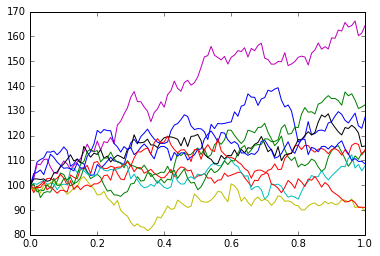

In [6]:
[test_mcpaths[i].plot() for i in range(npaths)]

Defining the Black formula, according to:

$$C(S_0,t) = e^{-rT} \left[FN(d_1) - KN(d_2)\right]$$

Where:

$$F = S_0e^{\left(r-q\right)t}$$

$$d_1 = \frac{1}{\sigma\sqrt{t}} \left[ \ln{\left( \frac{S_0}{K} \right) } + \left( r -q + \frac{\sigma^2}{2} \right) \left(t \right) \right]$$

$$d_2 = d_1 - \sigma\sqrt{t}$$

In [74]:
def bsv(phi,S,K,r,q,vol,t):
    if(t>0):
        # calculate F
        F=S*np.exp((r-q)*t)

        # calculate d1 and d2
        sigma_rt = vol*np.sqrt(t)
        d1=(np.log(S/K)+(r-q+vol**2/2)*t)/(sigma_rt)
        d2=d1-sigma_rt

        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)

        # calculate delta and premium
        delta=phi*np.exp(-q*t)*Nd1
        premium=S*delta-phi*K*np.exp(-r*t)*Nd2
    else:
        delta=0
        premium=max(phi*(S-K),0)
    
    return [premium,delta]

Testing the function we can verify that results match with this [Black-Scholes Calculator](http://www.math.drexel.edu/~pg/fin/VanillaCalculator.html) from Drexel University
![title](images/bs_calculator.png)

In [75]:
call = 1
put = -1
S0=100
r=0.1
q=.02
vol=0.2
T=1
K=100
[bsv(call,S0,K,r,q,vol,T),bsv(put,S0,K,r,q,vol,T)]

[[11.866121135383175, 0.67777058718221128],
 [4.3299956083035909, -0.30242808612454397]]


Function for calculating portfolio P&L and cash flow value given a path

In [26]:
def calcportfolio(path,phi,K,r,q,vol,T):
    nstp=len(path)-1

    # calculate t,S(t),premium(t),delta(t) using Black Scholes function
    bsvpath=[[path.index[i],path.values[i]]+bsv(call,path.values[i],K,r,q,vol,1-path.index[i])\
            for i in range(len(path))]
    df = pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])
       
    # generate cfwprem column to include cash flows regarding premium
    df['cfwprem']=0
    
    # the first cash flow is the price payed to enter the option
    df.loc[0,'cfwprem']=-df['premium'][0]
    
    # at the maturity:
    # - all premium, if any, becomes cash flow regarding option settlement
    # - there is no delta as option expires and we should withdraw the position on asset
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    df.loc[nstp,'delta']=0
       
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    
    # calculate changes in delta
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0

    # cashflows for heding the portfolio buying/selling delta quantities of the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]

    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)

    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']

    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]

    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']

    # consolidated discount factor
    return df

some function test, just to see the data frame´s face

In [27]:
call=1
put=-1
nsteps=10
S0=100
r=0.1
q=0
vol=0.2
T=1
K=100
mypath = mcpath(nsteps,S0,r,vol,T)
calcportfolio(mypath,call,K,r,q,vol,T)

,time,spot,premium,delta,cfwprem,timechg,dltchg,spotchg,cfwspot,cfwdivid,cfwprer,balance,portf
0,0.0,100.000000,13.269677,0.725747,-13.269677,0.0,0.000000,0.000000,72.574688,0.0,59.305012,59.305012,0.000000
1,0.1,100.638544,12.792374,0.726665,0.000000,0.1,0.000918,0.638544,0.092387,-0.0,0.092387,59.993424,-0.344699
2,0.2,105.931885,15.858718,0.804773,0.000000,0.1,0.078109,5.293341,8.274189,-0.0,8.274189,68.870557,-0.521895
3,0.3,110.204347,18.377694,0.860524,0.000000,0.1,0.055750,4.272462,6.143908,-0.0,6.143908,75.706626,-0.749123
4,0.4,114.356449,20.986153,0.908355,0.000000,0.1,0.047831,4.152102,5.469831,-0.0,5.469831,81.937321,-0.952781
5,0.5,117.835076,23.136319,0.943487,0.000000,0.1,0.035132,3.478628,4.139786,-0.0,4.139786,86.900591,-1.138961
6,0.6,121.514771,25.604478,0.972572,0.000000,0.1,0.029085,3.679695,3.534299,-0.0,3.534299,91.308255,-1.269181
7,0.7,126.490461,29.477037,0.993317,0.000000,0.1,0.020744,4.975689,2.623957,-0.0,2.623957,94.849875,-1.318177
8,0.8,139.527528,41.507755,0.999967,0.000000,0.1,0.006651,13.037068,0.927940,-0.0,0.927940,96.731071,-1.284139
9,0.9,131.813697,32.808718,0.999997,0.000000,0.1,0.000030,-7.713831,0.003969,-0.0,0.003969,97.707204,-1.297433


generating a histogram of portfolio P&L

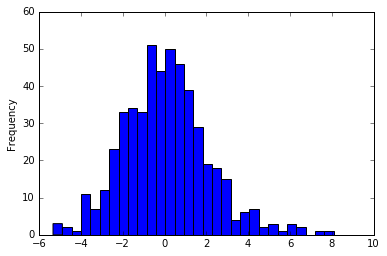

In [28]:
npaths=500
pls=pd.Series([calcportfolio(mcpath(nsteps, S0, r, vol, T),call,K,r,q,vol,T)['portf'][nsteps] for i in range(npaths)])
pls.plot(kind='hist',bins=30)

## Exercise 1

Change the the Black&Scholes and portfolio function to receive implied and realized volatity

In [76]:
def bsv2(phi,S,K,r,q,vol_pricing,vol_delta,t):
    if(t>0):
        # calculate F
        F=S*np.exp((r-q)*t)

        # calculate d1 and d2
        sigma_rt = vol_pricing*np.sqrt(t)
        d1=(np.log(S/K)+(r-q+vol_pricing**2/2)*t)/(sigma_rt)
        d2=d1-sigma_rt

        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)

        # calculate premium
        delta=phi*np.exp(-q*t)*Nd1
        premium=S*delta-phi*K*np.exp(-r*t)*Nd2

        # calculate delta
        sigma_rtdelta=vol_delta*np.sqrt(t)
        d1delta=(np.log(S/K)+(r-q+vol_delta**2/2)*t)/(sigma_rtdelta)
        Nd1delta=st.norm.cdf(phi*d1delta)
        delta=phi*np.exp(-q*t)*Nd1delta
    else:
        delta=0
        premium=max(phi*(S-K),0)
        
    return [premium,delta]

In [108]:
def calcportfolio2(path,phi,K,r,q,vol_pricing,vol_delta,T):
    nstp=len(path)-1

    # calculate t,S(t),premium(t),delta(t) using Black Scholes function
    bsvpath=[[path.index[i],path.values[i]]+bsv2(call,path.values[i],K,r,q,vol_pricing,vol_delta,1-path.index[i])\
            for i in range(len(path))]
    df = pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])
       
    # generate cfwprem column to include cash flows regarding premium
    df['cfwprem']=0
    
    # the first cash flow is the price payed to enter the option
    df.loc[0,'cfwprem']=-df['premium'][0]
    
    # at the maturity:
    # - all premium, if any, becomes cash flow regarding option settlement
    # - there is no delta as option expires and we should withdraw the position on asset
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    df.loc[nstp,'delta']=0
       
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    
    # calculate changes in delta
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0

    # cashflows for heding the portfolio buying/selling delta quantities of the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]

    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)

    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']

    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]

    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']

    # consolidated discount factor
    return df

Define parameters

In [194]:
call=1
put=-1
S0=100
r=0
q=0
vol_pricing=.2
vol_delta=.3
T=1
K=100
nsteps=500
npaths=500

Generate paths

In [195]:
paths = [mcpath(nsteps, S0, r, vol_delta, T) for i in range(npaths)]

### Hedging using Realized Vol

P&L portfolio envolution

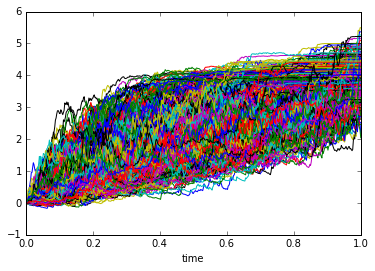

In [196]:
portfsVolReal=[calcportfolio2(paths[i],call,K,r,q,vol_pricing,vol_delta,T) for i in range(npaths)]
df=pd.DataFrame([pd.Series(portfsVolReal[i]['portf'].values,index=portfsVolReal[i]['time']) for i in range(npaths)])
df.transpose().plot(legend=None)

Final P&L distribution

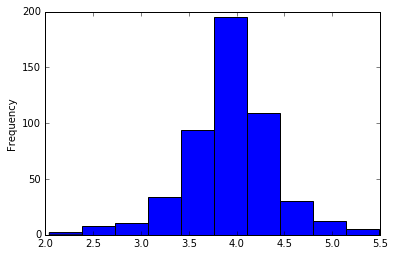

In [197]:
pls=pd.Series([portfsVolReal[i]['portf'][nsteps] for i in range(npaths)])
pls.plot(kind='hist',bins=10)

### Hedging using Implied Vol

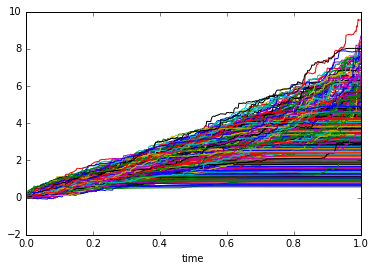

In [198]:
portfsVolImpl=[calcportfolio2(paths[i],call,K,r,q,vol_pricing,vol_pricing,T) for i in range(npaths)]
df=pd.DataFrame([pd.Series(portfsVolImpl[i]['portf'].values,index=portfsVolImpl[i]['time']) for i in range(npaths)])
df.transpose().plot(legend=None)

Final P&L distribution

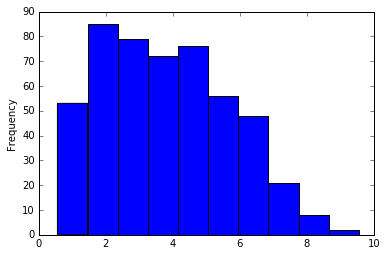

In [199]:
pls=pd.Series([portfsVolImpl[i]['portf'][nsteps] for i in range(npaths)])
pls.plot(kind='hist',bins=10)

## Exercise 2

In [200]:
import scipy.optimize as opt

In [201]:
def bev(vol,path,phi,K,r,q,T):
    plfinal = calcportfolio(path,1,100,0,0,vol,1)['portf'][len(path)-1]
    return plfinal

In [202]:
bevs = pd.Series([opt.newton(bev, 0.2, args=(paths[i],call,K,r,q,T)) for i in range(npaths)])

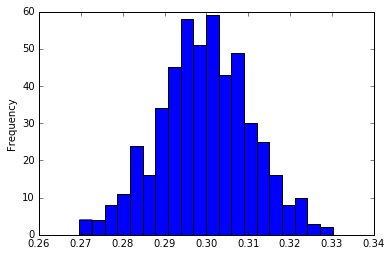

In [203]:
bevs.plot(kind='hist',bins=20)

In [204]:
bevs

0      0.273784
1      0.310563
2      0.295886
3      0.299581
4      0.289731
5      0.293873
6      0.304474
7      0.273123
8      0.293424
9      0.304570
10     0.311862
11     0.281667
12     0.299631
13     0.306673
14     0.295970
15     0.303193
16     0.284757
17     0.308898
18     0.321234
19     0.279996
20     0.296003
21     0.297327
22     0.288975
23     0.275896
24     0.286974
25     0.293612
26     0.299873
27     0.310081
28     0.309365
29     0.310436
         ...   
470    0.293487
471    0.289917
472    0.324261
473    0.307563
474    0.312071
475    0.297989
476    0.286889
477    0.280403
478    0.306353
479    0.290054
480    0.284167
481    0.317978
482    0.298855
483    0.312607
484    0.314161
485    0.291057
486    0.320743
487    0.289667
488    0.299924
489    0.285329
490    0.308137
491    0.269692
492    0.313374
493    0.296222
494    0.297451
495    0.322835
496    0.321502
497    0.301540
498    0.297973
499    0.279235
dtype: float64